In [13]:
import matplotlib as mpl # python 绘图库
import matplotlib.pyplot as plt # python 2D 绘图库
import numpy as np # 数学库，矩阵数组等
import sklearn
import pandas as pd # 大数据处理模块
import os # 处理文件和目录
import sys # 解释器使用或维护一些变量的访问，以及与解释器强交互的函数
import time # 格式化日期与时间
import tensorflow as tf
 
from tensorflow import keras
 
#显示重要库的对应版本
print(tf.__version__)
print(sys.version_info)
for module in mpl,np,pd,sklearn,tf,keras:
    print(module.__name__,module.__version__)

2.4.1
sys.version_info(major=3, minor=8, micro=5, releaselevel='final', serial=0)
matplotlib 3.3.2
numpy 1.19.5
pandas 1.1.3
sklearn 0.24.0
tensorflow 2.4.1
tensorflow.keras 2.4.0


In [14]:
from sklearn.datasets import fetch_california_housing
# 引入加州房价预测数据
housing = fetch_california_housing()
# 显示数据的说明，数据的矩阵形状，标签的形状
print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [40]:
# 引入机器学习数据集分割库
from sklearn.model_selection import train_test_split
# 引入预测房价的 data，target，并切分数据为 训练集（训练集中又该分为训练集和验证集） 与 测试集，
# x 为训练集,y 为测试集，这里将数据切割为 4 个部分，训练集的特征，验证集的特征，训练集的标签，验证集的标签
# 没有填写训练集与验证的分割比例的话，默认为 0.75

x_train_all,x_test,y_train_all,y_test = train_test_split(
    housing.data,housing.target,random_state=7)
 
# 将大训练集分割为小训练集与验证集
x_train,x_valid,y_train,y_valid =train_test_split(
    x_train_all,y_train_all,random_state=11)
 
# 显示训练集，验证集，测试集的形状
print(x_train.shape,y_train.shape)
print(x_valid.shape,y_valid.shape)
print(x_test.shape,y_test.shape)

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [41]:
y_train

array([3.226, 1.514, 1.598, ..., 1.5  , 2.636, 1.925])

In [42]:
# 引入标准化库 ：计算训练集的平均值和标准差，以便测试数据集使用相同的变换
from sklearn import preprocessing
 
# 引入标准化函数
scaler = preprocessing.StandardScaler()
# 训练集，验证集，测试集标准化
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

In [43]:
x_test_scaled

array([[-0.96598484,  0.19206119, -1.04889736, ...,  0.01281729,
        -0.73906413,  0.63164745],
       [ 0.24771283,  0.11196095, -0.15638057, ..., -0.0636657 ,
        -0.85570637,  0.63164745],
       [-0.08829461,  1.87416616, -0.23201227, ..., -0.1387746 ,
         1.0105695 , -1.33078543],
       ...,
       [-0.39025373,  0.91296332, -0.26692829, ..., -0.01752361,
        -0.74839551,  0.72152988],
       [-0.93950281,  1.23336426, -0.96485108, ...,  0.18553096,
         0.58599173, -1.09109897],
       [ 0.94551706,  0.75276284,  0.23183458, ..., -0.04272383,
        -0.71106999,  0.74150375]])

In [53]:
# 实现多输入 这里使用函数式的方法
# 我们假设我们将前 5 个 feature 输入 wide 模型，后 6 个 feature 输入 deep 模型，一共 8 个 feature ，也就是说， wide and deep 有交集部分
input_wide = keras.layers.Input(shape=[5])
input_deep = keras.layers.Input(shape=[6])
# deep model 有两个隐藏层
hidden1 = keras.layers.Dense(30,activation='relu')(input_deep)
hidden2 = keras.layers.Dense(15,activation='relu')(hidden1)
# 合并两个模型的输出
concat = keras.layers.concatenate([input_wide,hidden2])
output =keras.layers.Dense(1)(concat)
# 模型的输入为两个模型的输入，输出只有一个
model = keras.models.Model(inputs = [input_wide,input_deep],
                            outputs = [output])

In [54]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 30)           210         input_7[0][0]                    
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 15)           465         dense_9[0][0]                    
____________________________________________________________________________________________

In [55]:
model.compile(loss="mean_squared_error",optimizer="Ftrl")

In [56]:
callbacks = [keras.callbacks.EarlyStopping(
                patience= 5,min_delta=1e-2)]

In [57]:
# wide 模型的输入，前 5 个特征的数据集 ,deep 模型输入后 6 个
x_train_scaled_wide = x_train_scaled[:,:5]
x_train_scaled_deep = x_train_scaled[:,2:]
# 验证集和测试集同上
x_valid_scaled_wide = x_valid_scaled[:,:5]
x_valid_scaled_deep = x_valid_scaled[:,2:]
x_test_scaled_wide = x_test_scaled[:,:5]
x_test_scaled_deep = x_test_scaled[:,2:]

In [58]:
history = model.fit([x_train_scaled_wide,x_train_scaled_deep],
                    y_train,
                    validation_data=(
                                    [x_valid_scaled_wide,x_valid_scaled_deep],
                                    y_valid),
                    epochs = 200,
                    callbacks = callbacks
                    )

Epoch 1/200
363/363 [==============================] - 5s 7ms/step - loss: 5.9362 - val_loss: 5.8513
Epoch 2/200
363/363 [==============================] - 2s 6ms/step - loss: 5.3600 - val_loss: 5.2879
Epoch 3/200
363/363 [==============================] - 3s 7ms/step - loss: 4.8810 - val_loss: 4.6622
Epoch 4/200
363/363 [==============================] - 2s 6ms/step - loss: 4.2539 - val_loss: 4.0506
Epoch 5/200
363/363 [==============================] - 2s 6ms/step - loss: 3.6729 - val_loss: 3.5066
Epoch 6/200
363/363 [==============================] - 3s 7ms/step - loss: 3.1336 - val_loss: 3.0540
Epoch 7/200
363/363 [==============================] - 2s 6ms/step - loss: 2.7738 - val_loss: 2.6968
Epoch 8/200
363/363 [==============================] - 2s 6ms/step - loss: 2.4800 - val_loss: 2.4255
Epoch 9/200
363/363 [==============================] - 2s 6ms/step - loss: 2.2515 - val_loss: 2.2250
Epoch 10/200
363/363 [==============================] - 2s 6ms/step - loss: 2.0060 - val_lo

363/363 [==============================] - 3s 7ms/step - loss: 0.8638 - val_loss: 0.9300
Epoch 82/200
363/363 [==============================] - 2s 6ms/step - loss: 0.8702 - val_loss: 0.9255
Epoch 83/200
363/363 [==============================] - 2s 5ms/step - loss: 0.8633 - val_loss: 0.9211
Epoch 84/200
363/363 [==============================] - 2s 5ms/step - loss: 0.8743 - val_loss: 0.9168
Epoch 85/200
363/363 [==============================] - 2s 5ms/step - loss: 0.8631 - val_loss: 0.9126
Epoch 86/200
363/363 [==============================] - 2s 5ms/step - loss: 0.8664 - val_loss: 0.9084
Epoch 87/200
363/363 [==============================] - 2s 5ms/step - loss: 0.8489 - val_loss: 0.9044
Epoch 88/200
363/363 [==============================] - 2s 6ms/step - loss: 0.8362 - val_loss: 0.9004
Epoch 89/200
363/363 [==============================] - 2s 6ms/step - loss: 0.8622 - val_loss: 0.8965
Epoch 90/200
363/363 [==============================] - 2s 5ms/step - loss: 0.8603 - val_loss: 

In [39]:
model

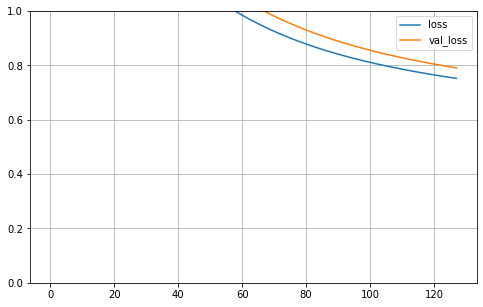

In [59]:
# 设定图表展示函数，将模型训练的接受对象 history 输入到该函数中
def plot_learning_curves(history):
# 将 history 获取到的训练过程的参数变化的字典变为矩阵形状，并设定图的尺寸大小为 8 和 5
    pd.DataFrame(history.history).plot(figsize=(8,5))
# 显示网格
    plt.grid(True)
# 设置坐标范围 ，设定 y 为 0~1 之间
    plt.gca().set_ylim(0,1)
# 显示这张图
    plt.show()
plot_learning_curves(history)

In [60]:
# 输入测试集的特征与标签
model.evaluate([x_test_scaled_wide, x_test_scaled_deep],y_test)

162/162 [==============================] - 0s 711us/step - loss: 0.7535


0.7535200715065002